In [4]:
import numpy as np
import pandas as pd
import os
import gym
import time
import json
from copy import deepcopy

import keras
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Activation, Flatten, BatchNormalization, Conv2D, Add
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.callbacks import History
from keras.backend import tf as ktf
from keras.callbacks import Callback as KerasCallback, CallbackList as KerasCallbackList
from keras.callbacks import EarlyStopping, TensorBoard, CSVLogger
from keras.utils.generic_utils import Progbar
from keras import backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy, Policy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import ModelIntervalCheckpoint, FileLogger

from IPython import display
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

# check our devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6010308570287474766
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 441581568
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9706691044120419219
physical_device_desc: "device: 0, name: GeForce GTX 650, pci bus id: 0000:01:00.0, compute capability: 3.0"
]


In [112]:
from gym import error, spaces

class Env(object):
    """The abstract environment class that is used by all agents. This class has the exact
    same API that OpenAI Gym uses so that integrating with it is trivial. In contrast to the
    OpenAI Gym implementation, this class only defines the abstract methods without any actual
    implementation.
    To implement your own environment, you need to define the following methods:
    - `step`
    - `reset`
    - `render`
    - `close`
    Refer to the [Gym documentation](https://gym.openai.com/docs/#environments).
    """
    reward_range = (-np.inf, np.inf)
    action_space = spaces.Discrete(4)
    observation_space = spaces.Box(low=-1, high=1, shape=(3,3))

    def step(self, action):
        self.step_num += 1
        done = False
        previous_distance = abs(self.pos[0] - 2) + abs(self.pos[1] - 2)
        
        if action == 0:
            # up
            self.pos = (max(self.pos[0] - 1, 0), self.pos[1])
        if action == 1:
            # down
            self.pos = (min(self.pos[0] + 1, 2), self.pos[1])
        if action == 2:
            # left
            self.pos = (self.pos[0], max(self.pos[1] - 1, 0))
        if action == 3:
            # right
            self.pos = (self.pos[0], min(self.pos[1] + 1, 2))
            
        current_distance = abs(self.pos[0] - 2) + abs(self.pos[1] - 2)
        
        reward = -0.1
        
        if previous_distance < current_distance:
            reward = -1.
            
        if previous_distance > current_distance:
            reward = 1.
            
        if current_distance == 0:
            done = True
        
        self.observation = self.default_view.copy()
        self.observation[self.pos] = 0.5
        
        if self.step_num > 10:
            done= True
        
        return self.observation, reward, done, {}

    def reset(self):
        self.step_num = 0
        self.pos = (0,0)
        self.default_view = np.array([
            [0., 0., 0.],
            [0., 0., 0.],
            [0., 0., 1.]
        ])
        self.observation = self.default_view.copy()
        self.observation[self.pos] = 0.5
        return self.observation

    def render(self, mode='human', close=False):
        plt.imshow(self.observation)
        plt.show()
        
    
    def close(self):
        """Override in your subclass to perform any necessary cleanup.
        Environments will automatically close() themselves when
        garbage collected or when the program exits.
        """
        pass

    def seed(self, seed=None):
        """Sets the seed for this env's random number generator(s).
        # Returns
            Returns the list of seeds used in this env's random number generators
        """
        pass

    def configure(self, *args, **kwargs):
        """Provides runtime configuration to the environment.
        This configuration should consist of data that tells your
        environment how to run (such as an address of a remote server,
        or path to your ImageNet data). It should not affect the
        semantics of the environment.
        """
        raise NotImplementedError()

    def __del__(self):
        self.close()

    def __str__(self):
        return '<{} instance>'.format(type(self).__name__)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [113]:
env = Env()
nb_actions = env.action_space.n

input_shape = (1, 3, 3)

frames_input = keras.layers.Input(input_shape, name='frames')

flat = keras.layers.Flatten()(frames_input)
hidden_1 = keras.layers.Dense(512, activation='relu')(flat)
hidden_2 = keras.layers.Dense(512, activation='relu')(hidden_1)
output = keras.layers.Dense(nb_actions)(hidden_2)

model = keras.models.Model(inputs=frames_input, outputs=output)
optimizer = optimizer=keras.optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01)

memory = SequentialMemory(limit=1000, window_length=1)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 'eps', 1., 0., 0.0, 1000)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=500, 
               target_model_update=1000, policy=policy, test_policy=policy)
dqn.compile(optimizer, metrics=['mse'])

In [114]:
# train the DQN
env.reset()
hist = dqn.fit(env, nb_steps=5000, visualize=False, verbose=2)

Training for 5000 steps ...
   11/5000: episode: 1, duration: 0.702s, episode steps: 11, steps per second: 16, episode reward: 0.800, mean reward: 0.073 [-1.000, 1.000], mean action: 1.727 [0.000, 3.000], mean observation: 0.167 [0.000, 1.000], loss: --, mean_squared_error: --, mean_q: --, mean_eps: --
   18/5000: episode: 2, duration: 0.022s, episode steps: 7, steps per second: 320, episode reward: 3.900, mean reward: 0.557 [-1.000, 1.000], mean action: 1.571 [0.000, 3.000], mean observation: 0.151 [0.000, 1.000], loss: --, mean_squared_error: --, mean_q: --, mean_eps: --
   29/5000: episode: 3, duration: 0.033s, episode steps: 11, steps per second: 332, episode reward: 0.600, mean reward: 0.055 [-1.000, 1.000], mean action: 0.909 [0.000, 3.000], mean observation: 0.167 [0.000, 1.000], loss: --, mean_squared_error: --, mean_q: --, mean_eps: --
   40/5000: episode: 4, duration: 0.034s, episode steps: 11, steps per second: 321, episode reward: 1.900, mean reward: 0.173 [-1.000, 1.000], 

  354/5000: episode: 34, duration: 0.024s, episode steps: 11, steps per second: 462, episode reward: 3.300, mean reward: 0.300 [-0.100, 1.000], mean action: 1.000 [0.000, 3.000], mean observation: 0.157 [0.000, 1.000], loss: --, mean_squared_error: --, mean_q: --, mean_eps: --
  365/5000: episode: 35, duration: 0.019s, episode steps: 11, steps per second: 564, episode reward: -0.700, mean reward: -0.064 [-1.000, 1.000], mean action: 1.091 [0.000, 3.000], mean observation: 0.167 [0.000, 1.000], loss: --, mean_squared_error: --, mean_q: --, mean_eps: --
  376/5000: episode: 36, duration: 0.019s, episode steps: 11, steps per second: 593, episode reward: 1.300, mean reward: 0.118 [-1.000, 1.000], mean action: 1.182 [0.000, 3.000], mean observation: 0.167 [0.000, 1.000], loss: --, mean_squared_error: --, mean_q: --, mean_eps: --
  387/5000: episode: 37, duration: 0.017s, episode steps: 11, steps per second: 648, episode reward: 2.800, mean reward: 0.255 [-1.000, 1.000], mean action: 0.909 [

  628/5000: episode: 64, duration: 0.135s, episode steps: 11, steps per second: 81, episode reward: 2.600, mean reward: 0.236 [-1.000, 1.000], mean action: 1.364 [0.000, 3.000], mean observation: 0.167 [0.000, 1.000], loss: 0.063595, mean_squared_error: 0.358716, mean_q: 0.843621, mean_eps: 0.378000
  632/5000: episode: 65, duration: 0.056s, episode steps: 4, steps per second: 71, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.072064, mean_squared_error: 0.367738, mean_q: 0.852170, mean_eps: 0.370500
  637/5000: episode: 66, duration: 0.067s, episode steps: 5, steps per second: 74, episode reward: 3.900, mean reward: 0.780 [-0.100, 1.000], mean action: 1.800 [1.000, 3.000], mean observation: 0.144 [0.000, 1.000], loss: 0.064179, mean_squared_error: 0.380046, mean_q: 0.863637, mean_eps: 0.366000
  648/5000: episode: 67, duration: 0.139s, episode steps: 11, steps per second: 79, episode reward: 

  804/5000: episode: 94, duration: 0.058s, episode steps: 4, steps per second: 69, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.052600, mean_squared_error: 0.386575, mean_q: 0.899844, mean_eps: 0.198500
  808/5000: episode: 95, duration: 0.055s, episode steps: 4, steps per second: 72, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.068539, mean_squared_error: 0.404069, mean_q: 0.889691, mean_eps: 0.194500
  812/5000: episode: 96, duration: 0.058s, episode steps: 4, steps per second: 69, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.046819, mean_squared_error: 0.400833, mean_q: 0.905375, mean_eps: 0.190500
  818/5000: episode: 97, duration: 0.082s, episode steps: 6, steps per second: 73, episode reward: 4.00

  940/5000: episode: 125, duration: 0.062s, episode steps: 4, steps per second: 65, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.048300, mean_squared_error: 0.392013, mean_q: 0.933800, mean_eps: 0.062500
  944/5000: episode: 126, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.029658, mean_squared_error: 0.399319, mean_q: 0.939269, mean_eps: 0.058500
  948/5000: episode: 127, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.034120, mean_squared_error: 0.391583, mean_q: 0.946710, mean_eps: 0.054500
  952/5000: episode: 128, duration: 0.062s, episode steps: 4, steps per second: 64, episode reward: 

 1053/5000: episode: 153, duration: 0.059s, episode steps: 4, steps per second: 67, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.090670, mean_squared_error: 0.912915, mean_q: 1.635656, mean_eps: 0.000000
 1063/5000: episode: 154, duration: 0.147s, episode steps: 10, steps per second: 68, episode reward: 3.400, mean reward: 0.340 [-0.100, 1.000], mean action: 2.600 [1.000, 3.000], mean observation: 0.156 [0.000, 1.000], loss: 0.084477, mean_squared_error: 0.885038, mean_q: 1.666763, mean_eps: 0.000000
 1067/5000: episode: 155, duration: 0.059s, episode steps: 4, steps per second: 68, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.075051, mean_squared_error: 0.824632, mean_q: 1.655593, mean_eps: 0.000000
 1071/5000: episode: 156, duration: 0.061s, episode steps: 4, steps per second: 65, episode reward

 1217/5000: episode: 181, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.061532, mean_squared_error: 0.814422, mean_q: 1.602478, mean_eps: 0.000000
 1221/5000: episode: 182, duration: 0.059s, episode steps: 4, steps per second: 68, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.064564, mean_squared_error: 0.782434, mean_q: 1.604459, mean_eps: 0.000000
 1225/5000: episode: 183, duration: 0.061s, episode steps: 4, steps per second: 66, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.038220, mean_squared_error: 0.761748, mean_q: 1.595898, mean_eps: 0.000000
 1229/5000: episode: 184, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 

 1330/5000: episode: 209, duration: 0.058s, episode steps: 4, steps per second: 69, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.017294, mean_squared_error: 0.695171, mean_q: 1.613278, mean_eps: 0.000000
 1334/5000: episode: 210, duration: 0.060s, episode steps: 4, steps per second: 66, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.026526, mean_squared_error: 0.769100, mean_q: 1.664147, mean_eps: 0.000000
 1338/5000: episode: 211, duration: 0.058s, episode steps: 4, steps per second: 69, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.014616, mean_squared_error: 0.757253, mean_q: 1.640741, mean_eps: 0.000000
 1342/5000: episode: 212, duration: 0.061s, episode steps: 4, steps per second: 66, episode reward: 

 1442/5000: episode: 237, duration: 0.058s, episode steps: 4, steps per second: 70, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.007412, mean_squared_error: 0.604350, mean_q: 1.547955, mean_eps: 0.000000
 1446/5000: episode: 238, duration: 0.058s, episode steps: 4, steps per second: 69, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.010773, mean_squared_error: 0.625428, mean_q: 1.593914, mean_eps: 0.000000
 1450/5000: episode: 239, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.011025, mean_squared_error: 0.676281, mean_q: 1.624455, mean_eps: 0.000000
 1454/5000: episode: 240, duration: 0.057s, episode steps: 4, steps per second: 71, episode reward: 

 1554/5000: episode: 265, duration: 0.060s, episode steps: 4, steps per second: 67, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.001289, mean_squared_error: 0.660241, mean_q: 1.661619, mean_eps: 0.000000
 1558/5000: episode: 266, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.003759, mean_squared_error: 0.634628, mean_q: 1.586773, mean_eps: 0.000000
 1562/5000: episode: 267, duration: 0.058s, episode steps: 4, steps per second: 68, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.011439, mean_squared_error: 0.697556, mean_q: 1.687298, mean_eps: 0.000000
 1566/5000: episode: 268, duration: 0.054s, episode steps: 4, steps per second: 74, episode reward: 

 1666/5000: episode: 293, duration: 0.061s, episode steps: 4, steps per second: 65, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000407, mean_squared_error: 0.690741, mean_q: 1.662091, mean_eps: 0.000000
 1670/5000: episode: 294, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000166, mean_squared_error: 0.717354, mean_q: 1.711493, mean_eps: 0.000000
 1674/5000: episode: 295, duration: 0.055s, episode steps: 4, steps per second: 73, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.009406, mean_squared_error: 0.634470, mean_q: 1.590350, mean_eps: 0.000000
 1678/5000: episode: 296, duration: 0.056s, episode steps: 4, steps per second: 71, episode reward: 

 1778/5000: episode: 321, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.001173, mean_squared_error: 0.693242, mean_q: 1.663597, mean_eps: 0.000000
 1782/5000: episode: 322, duration: 0.060s, episode steps: 4, steps per second: 67, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.002918, mean_squared_error: 0.686519, mean_q: 1.651180, mean_eps: 0.000000
 1786/5000: episode: 323, duration: 0.062s, episode steps: 4, steps per second: 65, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000422, mean_squared_error: 0.713193, mean_q: 1.714087, mean_eps: 0.000000
 1790/5000: episode: 324, duration: 0.063s, episode steps: 4, steps per second: 63, episode reward: 

 1890/5000: episode: 349, duration: 0.053s, episode steps: 4, steps per second: 75, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000067, mean_squared_error: 0.656706, mean_q: 1.651193, mean_eps: 0.000000
 1894/5000: episode: 350, duration: 0.060s, episode steps: 4, steps per second: 66, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000163, mean_squared_error: 0.673662, mean_q: 1.633053, mean_eps: 0.000000
 1898/5000: episode: 351, duration: 0.059s, episode steps: 4, steps per second: 68, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.002815, mean_squared_error: 0.711765, mean_q: 1.689369, mean_eps: 0.000000
 1902/5000: episode: 352, duration: 0.058s, episode steps: 4, steps per second: 69, episode reward: 

 2002/5000: episode: 377, duration: 0.062s, episode steps: 4, steps per second: 64, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.061249, mean_squared_error: 0.755720, mean_q: 1.740407, mean_eps: 0.000000
 2006/5000: episode: 378, duration: 0.061s, episode steps: 4, steps per second: 66, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.136942, mean_squared_error: 0.912500, mean_q: 1.893277, mean_eps: 0.000000
 2010/5000: episode: 379, duration: 0.060s, episode steps: 4, steps per second: 66, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.086476, mean_squared_error: 0.955326, mean_q: 1.957108, mean_eps: 0.000000
 2014/5000: episode: 380, duration: 0.061s, episode steps: 4, steps per second: 66, episode reward: 

 2114/5000: episode: 405, duration: 0.060s, episode steps: 4, steps per second: 67, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.004572, mean_squared_error: 1.262326, mean_q: 2.332437, mean_eps: 0.000000
 2118/5000: episode: 406, duration: 0.058s, episode steps: 4, steps per second: 69, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.006459, mean_squared_error: 1.167988, mean_q: 2.204559, mean_eps: 0.000000
 2122/5000: episode: 407, duration: 0.057s, episode steps: 4, steps per second: 71, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.003482, mean_squared_error: 1.105707, mean_q: 2.125342, mean_eps: 0.000000
 2126/5000: episode: 408, duration: 0.062s, episode steps: 4, steps per second: 65, episode reward: 

 2226/5000: episode: 433, duration: 0.060s, episode steps: 4, steps per second: 66, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.002161, mean_squared_error: 1.129991, mean_q: 2.203868, mean_eps: 0.000000
 2230/5000: episode: 434, duration: 0.067s, episode steps: 4, steps per second: 59, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.002601, mean_squared_error: 1.145786, mean_q: 2.212767, mean_eps: 0.000000
 2234/5000: episode: 435, duration: 0.055s, episode steps: 4, steps per second: 73, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.003429, mean_squared_error: 1.131673, mean_q: 2.195632, mean_eps: 0.000000
 2238/5000: episode: 436, duration: 0.060s, episode steps: 4, steps per second: 67, episode reward: 

 2338/5000: episode: 461, duration: 0.061s, episode steps: 4, steps per second: 65, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000590, mean_squared_error: 1.064331, mean_q: 2.129615, mean_eps: 0.000000
 2343/5000: episode: 462, duration: 0.072s, episode steps: 5, steps per second: 70, episode reward: 3.900, mean reward: 0.780 [-0.100, 1.000], mean action: 1.800 [1.000, 3.000], mean observation: 0.144 [0.000, 1.000], loss: 0.001124, mean_squared_error: 1.131921, mean_q: 2.209885, mean_eps: 0.000000
 2347/5000: episode: 463, duration: 0.054s, episode steps: 4, steps per second: 75, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000779, mean_squared_error: 1.025792, mean_q: 2.071064, mean_eps: 0.000000
 2354/5000: episode: 464, duration: 0.091s, episode steps: 7, steps per second: 77, episode reward:

 2491/5000: episode: 491, duration: 0.061s, episode steps: 4, steps per second: 65, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000532, mean_squared_error: 1.053659, mean_q: 2.104646, mean_eps: 0.000000
 2496/5000: episode: 492, duration: 0.068s, episode steps: 5, steps per second: 74, episode reward: 3.900, mean reward: 0.780 [-0.100, 1.000], mean action: 1.800 [1.000, 3.000], mean observation: 0.144 [0.000, 1.000], loss: 0.000560, mean_squared_error: 1.079757, mean_q: 2.141097, mean_eps: 0.000000
 2501/5000: episode: 493, duration: 0.070s, episode steps: 5, steps per second: 72, episode reward: 3.900, mean reward: 0.780 [-0.100, 1.000], mean action: 1.800 [1.000, 3.000], mean observation: 0.144 [0.000, 1.000], loss: 0.000700, mean_squared_error: 1.023378, mean_q: 2.075700, mean_eps: 0.000000
 2505/5000: episode: 494, duration: 0.059s, episode steps: 4, steps per second: 68, episode reward

 2610/5000: episode: 519, duration: 0.053s, episode steps: 4, steps per second: 75, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000373, mean_squared_error: 1.071636, mean_q: 2.127422, mean_eps: 0.000000
 2614/5000: episode: 520, duration: 0.054s, episode steps: 4, steps per second: 74, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000036, mean_squared_error: 1.006879, mean_q: 2.049784, mean_eps: 0.000000
 2618/5000: episode: 521, duration: 0.056s, episode steps: 4, steps per second: 71, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000078, mean_squared_error: 1.068029, mean_q: 2.122178, mean_eps: 0.000000
 2622/5000: episode: 522, duration: 0.059s, episode steps: 4, steps per second: 68, episode reward: 

 2722/5000: episode: 547, duration: 0.061s, episode steps: 4, steps per second: 66, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000004, mean_squared_error: 1.155828, mean_q: 2.244553, mean_eps: 0.000000
 2726/5000: episode: 548, duration: 0.065s, episode steps: 4, steps per second: 62, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000004, mean_squared_error: 1.055694, mean_q: 2.101447, mean_eps: 0.000000
 2730/5000: episode: 549, duration: 0.059s, episode steps: 4, steps per second: 68, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000003, mean_squared_error: 1.091684, mean_q: 2.156557, mean_eps: 0.000000
 2734/5000: episode: 550, duration: 0.064s, episode steps: 4, steps per second: 62, episode reward: 

 2834/5000: episode: 575, duration: 0.060s, episode steps: 4, steps per second: 67, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000000, mean_squared_error: 1.085653, mean_q: 2.143440, mean_eps: 0.000000
 2838/5000: episode: 576, duration: 0.063s, episode steps: 4, steps per second: 63, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000001, mean_squared_error: 0.973750, mean_q: 2.002936, mean_eps: 0.000000
 2842/5000: episode: 577, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000000, mean_squared_error: 1.078545, mean_q: 2.134098, mean_eps: 0.000000
 2846/5000: episode: 578, duration: 0.063s, episode steps: 4, steps per second: 64, episode reward: 

 2946/5000: episode: 603, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000000, mean_squared_error: 1.143205, mean_q: 2.232608, mean_eps: 0.000000
 2950/5000: episode: 604, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000000, mean_squared_error: 1.074940, mean_q: 2.134049, mean_eps: 0.000000
 2954/5000: episode: 605, duration: 0.060s, episode steps: 4, steps per second: 66, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000000, mean_squared_error: 1.093506, mean_q: 2.155911, mean_eps: 0.000000
 2958/5000: episode: 606, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 

 3103/5000: episode: 633, duration: 0.065s, episode steps: 4, steps per second: 61, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.002284, mean_squared_error: 1.249801, mean_q: 2.275478, mean_eps: 0.000000
 3107/5000: episode: 634, duration: 0.060s, episode steps: 4, steps per second: 67, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.013883, mean_squared_error: 1.282969, mean_q: 2.306286, mean_eps: 0.000000
 3111/5000: episode: 635, duration: 0.056s, episode steps: 4, steps per second: 71, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.001460, mean_squared_error: 1.250518, mean_q: 2.275915, mean_eps: 0.000000
 3115/5000: episode: 636, duration: 0.055s, episode steps: 4, steps per second: 73, episode reward: 

 3215/5000: episode: 661, duration: 0.060s, episode steps: 4, steps per second: 67, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000366, mean_squared_error: 1.310252, mean_q: 2.366133, mean_eps: 0.000000
 3219/5000: episode: 662, duration: 0.055s, episode steps: 4, steps per second: 73, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000281, mean_squared_error: 1.217654, mean_q: 2.253461, mean_eps: 0.000000
 3223/5000: episode: 663, duration: 0.056s, episode steps: 4, steps per second: 71, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000286, mean_squared_error: 1.155792, mean_q: 2.171092, mean_eps: 0.000000
 3227/5000: episode: 664, duration: 0.056s, episode steps: 4, steps per second: 72, episode reward: 

 3327/5000: episode: 689, duration: 0.058s, episode steps: 4, steps per second: 69, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000403, mean_squared_error: 1.352519, mean_q: 2.428323, mean_eps: 0.000000
 3331/5000: episode: 690, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.003693, mean_squared_error: 1.491364, mean_q: 2.603902, mean_eps: 0.000000
 3335/5000: episode: 691, duration: 0.058s, episode steps: 4, steps per second: 69, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.003724, mean_squared_error: 1.338987, mean_q: 2.415300, mean_eps: 0.000000
 3339/5000: episode: 692, duration: 0.061s, episode steps: 4, steps per second: 66, episode reward: 

 3451/5000: episode: 720, duration: 0.058s, episode steps: 4, steps per second: 69, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000348, mean_squared_error: 1.342417, mean_q: 2.409869, mean_eps: 0.000000
 3455/5000: episode: 721, duration: 0.059s, episode steps: 4, steps per second: 68, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000131, mean_squared_error: 1.296111, mean_q: 2.363932, mean_eps: 0.000000
 3459/5000: episode: 722, duration: 0.058s, episode steps: 4, steps per second: 69, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000391, mean_squared_error: 1.198135, mean_q: 2.243748, mean_eps: 0.000000
 3463/5000: episode: 723, duration: 0.060s, episode steps: 4, steps per second: 67, episode reward: 

 3563/5000: episode: 748, duration: 0.061s, episode steps: 4, steps per second: 66, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000262, mean_squared_error: 1.380968, mean_q: 2.459913, mean_eps: 0.000000
 3567/5000: episode: 749, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.003521, mean_squared_error: 1.284376, mean_q: 2.352507, mean_eps: 0.000000
 3571/5000: episode: 750, duration: 0.060s, episode steps: 4, steps per second: 67, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000446, mean_squared_error: 1.162324, mean_q: 2.193696, mean_eps: 0.000000
 3575/5000: episode: 751, duration: 0.057s, episode steps: 4, steps per second: 71, episode reward: 

 3675/5000: episode: 776, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.006564, mean_squared_error: 1.227020, mean_q: 2.271770, mean_eps: 0.000000
 3679/5000: episode: 777, duration: 0.059s, episode steps: 4, steps per second: 68, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.006245, mean_squared_error: 1.210851, mean_q: 2.257760, mean_eps: 0.000000
 3683/5000: episode: 778, duration: 0.058s, episode steps: 4, steps per second: 69, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000341, mean_squared_error: 1.297840, mean_q: 2.364631, mean_eps: 0.000000
 3687/5000: episode: 779, duration: 0.058s, episode steps: 4, steps per second: 69, episode reward: 

 3787/5000: episode: 804, duration: 0.058s, episode steps: 4, steps per second: 69, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.006449, mean_squared_error: 1.277416, mean_q: 2.328376, mean_eps: 0.000000
 3791/5000: episode: 805, duration: 0.061s, episode steps: 4, steps per second: 65, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.003045, mean_squared_error: 1.345349, mean_q: 2.427649, mean_eps: 0.000000
 3795/5000: episode: 806, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000216, mean_squared_error: 1.435715, mean_q: 2.540209, mean_eps: 0.000000
 3799/5000: episode: 807, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 

 3899/5000: episode: 832, duration: 0.064s, episode steps: 4, steps per second: 63, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000163, mean_squared_error: 1.334601, mean_q: 2.415130, mean_eps: 0.000000
 3903/5000: episode: 833, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000264, mean_squared_error: 1.340229, mean_q: 2.416442, mean_eps: 0.000000
 3907/5000: episode: 834, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000063, mean_squared_error: 1.311631, mean_q: 2.377500, mean_eps: 0.000000
 3911/5000: episode: 835, duration: 0.058s, episode steps: 4, steps per second: 69, episode reward: 

 4011/5000: episode: 860, duration: 0.060s, episode steps: 4, steps per second: 67, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.001361, mean_squared_error: 1.320292, mean_q: 2.383677, mean_eps: 0.000000
 4015/5000: episode: 861, duration: 0.064s, episode steps: 4, steps per second: 63, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.001217, mean_squared_error: 1.380817, mean_q: 2.482811, mean_eps: 0.000000
 4019/5000: episode: 862, duration: 0.056s, episode steps: 4, steps per second: 72, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000820, mean_squared_error: 1.541037, mean_q: 2.654059, mean_eps: 0.000000
 4023/5000: episode: 863, duration: 0.060s, episode steps: 4, steps per second: 67, episode reward: 

 4123/5000: episode: 888, duration: 0.060s, episode steps: 4, steps per second: 67, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000065, mean_squared_error: 1.451288, mean_q: 2.546423, mean_eps: 0.000000
 4127/5000: episode: 889, duration: 0.059s, episode steps: 4, steps per second: 68, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000068, mean_squared_error: 1.327939, mean_q: 2.394051, mean_eps: 0.000000
 4131/5000: episode: 890, duration: 0.058s, episode steps: 4, steps per second: 70, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000064, mean_squared_error: 1.401350, mean_q: 2.477394, mean_eps: 0.000000
 4135/5000: episode: 891, duration: 0.056s, episode steps: 4, steps per second: 72, episode reward: 

 4235/5000: episode: 916, duration: 0.064s, episode steps: 4, steps per second: 63, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000009, mean_squared_error: 1.340569, mean_q: 2.404503, mean_eps: 0.000000
 4239/5000: episode: 917, duration: 0.063s, episode steps: 4, steps per second: 64, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000007, mean_squared_error: 1.466338, mean_q: 2.589480, mean_eps: 0.000000
 4243/5000: episode: 918, duration: 0.053s, episode steps: 4, steps per second: 75, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000006, mean_squared_error: 1.329945, mean_q: 2.396354, mean_eps: 0.000000
 4247/5000: episode: 919, duration: 0.060s, episode steps: 4, steps per second: 67, episode reward: 

 4347/5000: episode: 944, duration: 0.056s, episode steps: 4, steps per second: 71, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000001, mean_squared_error: 1.329945, mean_q: 2.395169, mean_eps: 0.000000
 4351/5000: episode: 945, duration: 0.056s, episode steps: 4, steps per second: 72, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000001, mean_squared_error: 1.342536, mean_q: 2.418521, mean_eps: 0.000000
 4355/5000: episode: 946, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000001, mean_squared_error: 1.382430, mean_q: 2.472516, mean_eps: 0.000000
 4359/5000: episode: 947, duration: 0.058s, episode steps: 4, steps per second: 69, episode reward: 

 4459/5000: episode: 972, duration: 0.062s, episode steps: 4, steps per second: 65, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000000, mean_squared_error: 1.323793, mean_q: 2.394903, mean_eps: 0.000000
 4463/5000: episode: 973, duration: 0.062s, episode steps: 4, steps per second: 65, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000000, mean_squared_error: 1.447157, mean_q: 2.549074, mean_eps: 0.000000
 4467/5000: episode: 974, duration: 0.061s, episode steps: 4, steps per second: 66, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000000, mean_squared_error: 1.368091, mean_q: 2.472347, mean_eps: 0.000000
 4471/5000: episode: 975, duration: 0.056s, episode steps: 4, steps per second: 71, episode reward: 

 4571/5000: episode: 1000, duration: 0.061s, episode steps: 4, steps per second: 66, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000000, mean_squared_error: 1.439602, mean_q: 2.533466, mean_eps: 0.000000
 4575/5000: episode: 1001, duration: 0.057s, episode steps: 4, steps per second: 71, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000000, mean_squared_error: 1.324321, mean_q: 2.386875, mean_eps: 0.000000
 4579/5000: episode: 1002, duration: 0.056s, episode steps: 4, steps per second: 71, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000000, mean_squared_error: 1.294413, mean_q: 2.364105, mean_eps: 0.000000
 4583/5000: episode: 1003, duration: 0.064s, episode steps: 4, steps per second: 62, episode rewa

 4683/5000: episode: 1028, duration: 0.062s, episode steps: 4, steps per second: 64, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000000, mean_squared_error: 1.475843, mean_q: 2.587784, mean_eps: 0.000000
 4687/5000: episode: 1029, duration: 0.056s, episode steps: 4, steps per second: 72, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000000, mean_squared_error: 1.387213, mean_q: 2.456124, mean_eps: 0.000000
 4691/5000: episode: 1030, duration: 0.055s, episode steps: 4, steps per second: 73, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000000, mean_squared_error: 1.482493, mean_q: 2.579541, mean_eps: 0.000000
 4695/5000: episode: 1031, duration: 0.058s, episode steps: 4, steps per second: 70, episode rewa

 4795/5000: episode: 1056, duration: 0.065s, episode steps: 4, steps per second: 61, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000000, mean_squared_error: 1.296523, mean_q: 2.364343, mean_eps: 0.000000
 4799/5000: episode: 1057, duration: 0.058s, episode steps: 4, steps per second: 69, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000000, mean_squared_error: 1.501263, mean_q: 2.618450, mean_eps: 0.000000
 4803/5000: episode: 1058, duration: 0.063s, episode steps: 4, steps per second: 63, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000000, mean_squared_error: 1.406387, mean_q: 2.502966, mean_eps: 0.000000
 4807/5000: episode: 1059, duration: 0.054s, episode steps: 4, steps per second: 74, episode rewa

 4907/5000: episode: 1084, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000000, mean_squared_error: 1.380792, mean_q: 2.464480, mean_eps: 0.000000
 4911/5000: episode: 1085, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000000, mean_squared_error: 1.450802, mean_q: 2.565208, mean_eps: 0.000000
 4915/5000: episode: 1086, duration: 0.057s, episode steps: 4, steps per second: 70, episode reward: 4.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [1.000, 3.000], mean observation: 0.139 [0.000, 1.000], loss: 0.000000, mean_squared_error: 1.370474, mean_q: 2.441032, mean_eps: 0.000000
 4919/5000: episode: 1087, duration: 0.059s, episode steps: 4, steps per second: 68, episode rewa

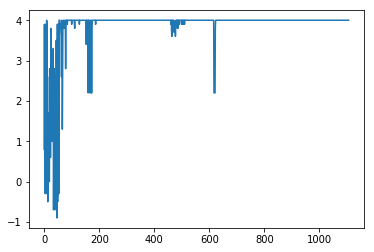

In [115]:
plt.plot(hist.history['episode_reward'])
plt.show()

In [116]:
def test(self, env, nb_episodes=1, action_repetition=1, callbacks=None, visualize=True,
         nb_max_episode_steps=None, nb_max_start_steps=0, start_step_policy=None, verbose=1):
    if not self.compiled:
        raise RuntimeError('Your tried to test your agent but it hasn\'t been compiled yet. Please call `compile()` before `test()`.')
    if action_repetition < 1:
        raise ValueError('action_repetition must be >= 1, is {}'.format(action_repetition))

    self.training = False
    self.step = 0

    callbacks = [] if not callbacks else callbacks[:]

    if verbose >= 1:
        callbacks += [TestLogger()]
    if visualize:
        callbacks += [Visualizer()]
    history = History()
    callbacks += [history]
    callbacks = CallbackList(callbacks)
    if hasattr(callbacks, 'set_model'):
        callbacks.set_model(self)
    else:
        callbacks._set_model(self)
    callbacks._set_env(env)
    params = {
        'nb_episodes': nb_episodes,
    }
    if hasattr(callbacks, 'set_params'):
        callbacks.set_params(params)
    else:
        callbacks._set_params(params)

    self._on_test_begin()
    callbacks.on_train_begin()
    for episode in range(nb_episodes):
        callbacks.on_episode_begin(episode)
        episode_reward = 0.
        episode_step = 0

        # Obtain the initial observation by resetting the environment.
        self.reset_states()
        observation = deepcopy(env.reset())
        if self.processor is not None:
            observation = self.processor.process_observation(observation)
        assert observation is not None

        # Perform random starts at beginning of episode and do not record them into the experience.
        # This slightly changes the start position between games.
        nb_random_start_steps = 0 if nb_max_start_steps == 0 else np.random.randint(nb_max_start_steps)
        for _ in range(nb_random_start_steps):
            if start_step_policy is None:
                action = env.action_space.sample()
            else:
                action = start_step_policy(observation)
            if self.processor is not None:
                action = self.processor.process_action(action)
            callbacks.on_action_begin(action)
            observation, r, done, info = env.step(action)
            observation = deepcopy(observation)
            if self.processor is not None:
                observation, r, done, info = self.processor.process_step(observation, r, done, info)
            callbacks.on_action_end(action)
            if done:
                warnings.warn('Env ended before {} random steps could be performed at the start. You should probably lower the `nb_max_start_steps` parameter.'.format(nb_random_start_steps))
                observation = deepcopy(env.reset())
                if self.processor is not None:
                    observation = self.processor.process_observation(observation)
                break

        # Run the episode until we're done.
        done = False
        while not done:
            callbacks.on_step_begin(episode_step)

            action = self.forward(observation)
            q_values = self.compute_q_values(np.array([observation]))
            print("Q:", q_values)
            if self.processor is not None:
                action = self.processor.process_action(action)
            reward = 0.
            accumulated_info = {}
            for _ in range(action_repetition):
                callbacks.on_action_begin(action)
                observation, r, d, info = env.step(action)
                observation = deepcopy(observation)
                if self.processor is not None:
                    observation, r, d, info = self.processor.process_step(observation, r, d, info)
                callbacks.on_action_end(action)
                reward += r
                for key, value in info.items():
                    if not np.isreal(value):
                        continue
                    if key not in accumulated_info:
                        accumulated_info[key] = np.zeros_like(value)
                    accumulated_info[key] += value
                if d:
                    done = True
                    break
            if nb_max_episode_steps and episode_step >= nb_max_episode_steps - 1:
                done = True
            self.backward(reward, terminal=done)
            episode_reward += reward

            step_logs = {
                'action': action,
                'observation': observation,
                'reward': reward,
                'episode': episode,
                'info': accumulated_info,
            }
            callbacks.on_step_end(episode_step, step_logs)
            episode_step += 1
            self.step += 1

        # We are in a terminal state but the agent hasn't yet seen it. We therefore
        # perform one more forward-backward call and simply ignore the action before
        # resetting the environment. We need to pass in `terminal=False` here since
        # the *next* state, that is the state of the newly reset environment, is
        # always non-terminal by convention.
        self.forward(observation)
        self.backward(0., terminal=False)

        # Report end of episode.
        episode_logs = {
            'episode_reward': episode_reward,
            'nb_steps': episode_step,
        }
        callbacks.on_episode_end(episode, episode_logs)
    callbacks.on_train_end()
    self._on_test_end()

    return history


Testing for 1 episodes ...
Q: [0.8051367  3.9638166  0.66204226 2.9440558 ]


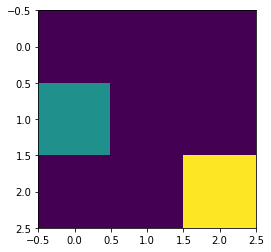

Q: [0.26076916 2.7462535  0.45243543 2.9665895 ]


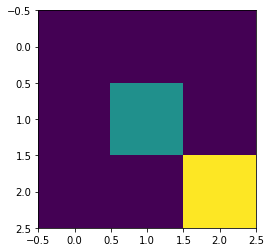

Q: [0.16215079 1.9870085  0.24613228 1.9883579 ]


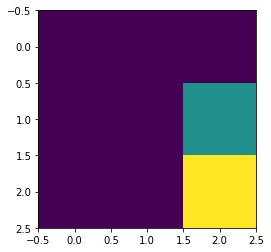

Q: [-0.09244825  0.99999774  0.1287565   0.8802551 ]


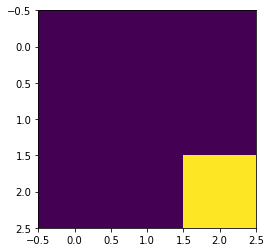

{'episode_reward': 4.0, 'nb_steps': 4}
Episode 1: reward: 4.000, steps: 4


In [117]:
# test the DQN
env.reset()
test(dqn, env, nb_episodes=1, callbacks=[BasicCallback()], visualize=True)